# Data protection

You need to protect the data of clients of an insurance company. Develop a method for transforming data so that it is difficult to recover personal information from it. Justify the correctness of its operation.

It is necessary to protect the data so that the quality of machine learning models does not deteriorate during conversion. There is no need to select the best model.

## Loading data

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

In [2]:
data = pd.read_csv('/datasets/insurance.csv')
data.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [3]:
data['Возраст'] = data['Возраст'].astype('int')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   int64  
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [5]:
data.isna().sum()

Пол                  0
Возраст              0
Зарплата             0
Члены семьи          0
Страховые выплаты    0
dtype: int64

In [6]:
data.duplicated().sum()

153

In [7]:
data = data.drop_duplicates()

In [8]:
len(data)

4847

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Пол,4847.0,0.498453,0.500049,0.0,0.0,0.0,1.0,1.0
Возраст,4847.0,31.023932,8.487995,18.0,24.0,30.0,37.0,65.0
Зарплата,4847.0,39895.811842,9972.953985,5300.0,33200.0,40200.0,46600.0,79000.0
Члены семьи,4847.0,1.203425,1.098664,0.0,0.0,1.0,2.0,6.0
Страховые выплаты,4847.0,0.152259,0.468934,0.0,0.0,0.0,0.0,5.0


<AxesSubplot:>

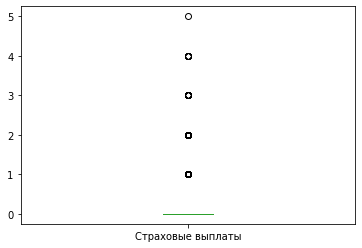

In [10]:
data['Страховые выплаты'].plot(kind='box')

<AxesSubplot:ylabel='Frequency'>

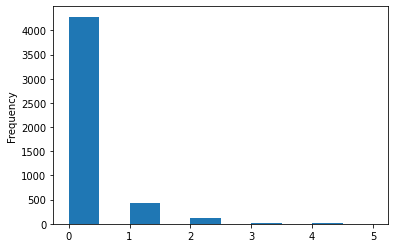

In [11]:
data['Страховые выплаты'].plot(kind='hist')

In [12]:
data['Страховые выплаты'].value_counts(normalize=True).mul(100)

0    88.384568
1     8.727048
2     2.351970
3     0.371364
4     0.144419
5     0.020631
Name: Страховые выплаты, dtype: float64

In [13]:
data = data.reset_index(drop=True)

## Matrix multiplication

**Question:** will the predictions of the regression model change if we chage the feature matrix by multiplying it with a random _invertible_ matrix?

Designations:

- $X$ — feature matrix (the zero column consists of ones)

- $y$ — target feature vector

- $P$ — matrix by which features are multiplied

- $w$ — vector of linear regression weights (zero element correspond to shift)

Predictions:

$$
a = Xw
$$

Learning Objective:

$$
w = \arg\min_w MSE(Xw, y)
$$

Training formula:

$$
w = (X^T X)^{-1} X^T y
$$

**Answer:** The quality of the model will not change

**Rationale:** The linear regression parameters of the original problem and the transformed one are related as follows

$$
w_1 = ((XP)^T (XP))^{-1} (XP)^T y
$$

$$
w_1 = (P^T X^T XP)^{-1} P^T X^T y
$$

$$
w_1 = P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y
$$

$$
w_1 = P^{-1} (X^T X)^{-1} X^T y
$$

$$
w_1 = P^{-1} w
$$

Model predictions will remain the same

$$
a_1 = XP w_1 = XP P^{-1}w = Xw = a
$$

## Conversion algorithm

**Algorithm**

1. creating a random square invertible matrix
2. multiplying the feature matrix by the created matrix
3. checking for significant differences between the resulting matrix and the original one
3. solving linear regression model

**Rationale**

From the reasoning of the previous paragraph it follows that the matrix of features and weights of the model will change, but its predictions will remain the same. Without the knowledge of the generated random matrix, it will be difficult to determine the original feature matrix. Data will be protected

## Algorithm check

In [14]:
X = data.drop(columns='Страховые выплаты').values
y = data['Страховые выплаты'].values

In [15]:
P = np.random.randint(11, size=(X.shape[1], X.shape[1]))
np.linalg.inv(P) # np.linalg.inv() is added to check if the matrix is revertible

array([[ 1.02857143,  0.5       ,  0.28571429, -0.71428571],
       [ 0.6       ,  0.        ,  0.5       , -0.5       ],
       [-1.77142857, -0.5       , -0.71428571,  1.28571429],
       [ 0.2       ,  0.        ,  0.        ,  0.        ]])

In [16]:
X1 = X @ P
X1

array([[347535., 396970., 347453.,  99213.],
       [266375., 304190., 266283.,  76008.],
       [147232., 168116., 147174.,  42000.],
       ...,
       [237474., 271292., 237434.,  67816.],
       [229097., 261706., 229053.,  65429.],
       [284431., 324918., 284375.,  81213.]])

In [17]:
X - X1

array([[-347534., -396929., -297853.,  -99212.],
       [-266375., -304144., -228283.,  -76007.],
       [-147232., -168087., -126174.,  -42000.],
       ...,
       [-237474., -271272., -203534.,  -67814.],
       [-229096., -261684., -196353.,  -65426.],
       [-284430., -324890., -243775.,  -81212.]])

As you can see, the difference between the original and the resulting matrix is ​​far from 0.

In [18]:
model = LinearRegression()
model.fit(X1, y)
predictions = model.predict(X1)
r2_score(y, predictions)

0.4302010044851797

In [19]:
predictions

array([ 0.51932881,  0.69230097,  0.09412742, ..., -0.26164511,
       -0.19394186,  0.05044763])

In [20]:
model.fit(X, y)
predictions = model.predict(X)
r2_score(y, predictions)

0.4302010044852066

In [21]:
predictions

array([ 0.51932881,  0.69230097,  0.09412742, ..., -0.26164511,
       -0.19394186,  0.05044763])

**Description of work and conclusion:**


Insurance company customer data was downloaded and prepared for analysis:


1. changed the client age data type to natural numbers like int
2. the dataset was checked for gaps: there are none
3. duplicate rows have been removed (153 rows out of 5000)
4. It was found that insurance payments were issued to only 12% of clients


Multiplying the feature matrix by the invertible matrix will change the weights of the linear regression model, but not its predictions, meaning the quality of the model will not change. The following algorithm is based on this idea.


The algorithm for protecting customer data can be described as follows:

1. creating a random square matrix with the dimension of the number of features
2. checking it for inverse: if its determinant is 0, then create a new matrix
3. multiplying the feature matrix by the generated matrix
4. checking for a significant difference between the resulting matrix and the original one: if it is close to zero, then create a new matrix
5. solving linear regression model

This algorithm will protect customer data, since without knowledge of the generated matrix it is difficult to derive the original data. However, as described above, the linear regression results will not change.


Checking the results of linear regression on the original data and processed by this algorithm confirms that the predictions remain the same and the R2 metric remains the same.